In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
from IPython.display import HTML
import matplotlib.animation
import matplotlib.gridspec as gridspec
from datetime import timedelta

import seaborn as sns
from pprint import pprint

from skimage import feature

from SentinelHubUtils import get_eopatch, delete_frame_eopatch, band_names
from WaterMaskUtils import get_water_mask, visualise_water_mask
from WaterUtils import myNDWI_index

In [2]:
df = pd.read_csv('./data/River_Arno.csv', sep=',', header=0, index_col=0)
df['Date'] = pd.to_datetime(df['Date']).dt.date
df = df.set_index('Date', verify_integrity=True)
df

,Rainfall_Le_Croci,Rainfall_Cavallina,Rainfall_S_Agata,Rainfall_Mangona,Rainfall_S_Piero,Rainfall_Vernio,Rainfall_Stia,Rainfall_Consuma,Rainfall_Incisa,Rainfall_Montevarchi,Rainfall_S_Savino,Rainfall_Laterina,Rainfall_Bibbiena,Rainfall_Camaldoli,Temperature_Firenze,Hydrometry_Nave_di_Rosano
Date,,,,,,,,,,,,,,,,
1998-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.82
1998-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.94
1998-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.11
1998-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.84
1998-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-26,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.34
2020-06-27,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.21
2020-06-28,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.30


# Sentinel Hub Images

![Firence Area](results/Firence_Area.png)

In [3]:
time_range = ('2015-01-01', df.index[-1].strftime('%Y-%m-%d'))

eopatch1 = get_eopatch(
    './data/03_EO_River_Arno_1',
    ((43.77491411647576, 11.100640547368934), (43.792682550748985, 11.137716614043402)),
    time_range,
)
eopatch1

eopatch data was loaded from local directory


EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(69, 205, 293, 7), dtype=float32)
    NDVI: numpy.ndarray(shape=(69, 205, 293, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(69, 205, 293, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(69, 205, 293, 1), dtype=uint8)
    CLP: numpy.ndarray(shape=(69, 205, 293, 1), dtype=uint8)
    IS_DATA: numpy.ndarray(shape=(69, 205, 293, 1), dtype=bool)
    VALID_DATA: numpy.ndarray(shape=(69, 205, 293, 1), dtype=bool)
  }
  scalar: {
    COVERAGE: numpy.ndarray(shape=(69, 1), dtype=float64)
  }
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 0.1
    service_type: 'processing'
    size_x: 293
    size_y: 205
    time_difference: datetime.timedelta(days=1)
    time_interval: ('2015-01-01T00:00:00', '2020-06-30T23:59:59')
  }
  bbox: BBox(((11.100640547368934, 43.77491411647576), (11.137716614043402, 43.792682550748985)), crs=

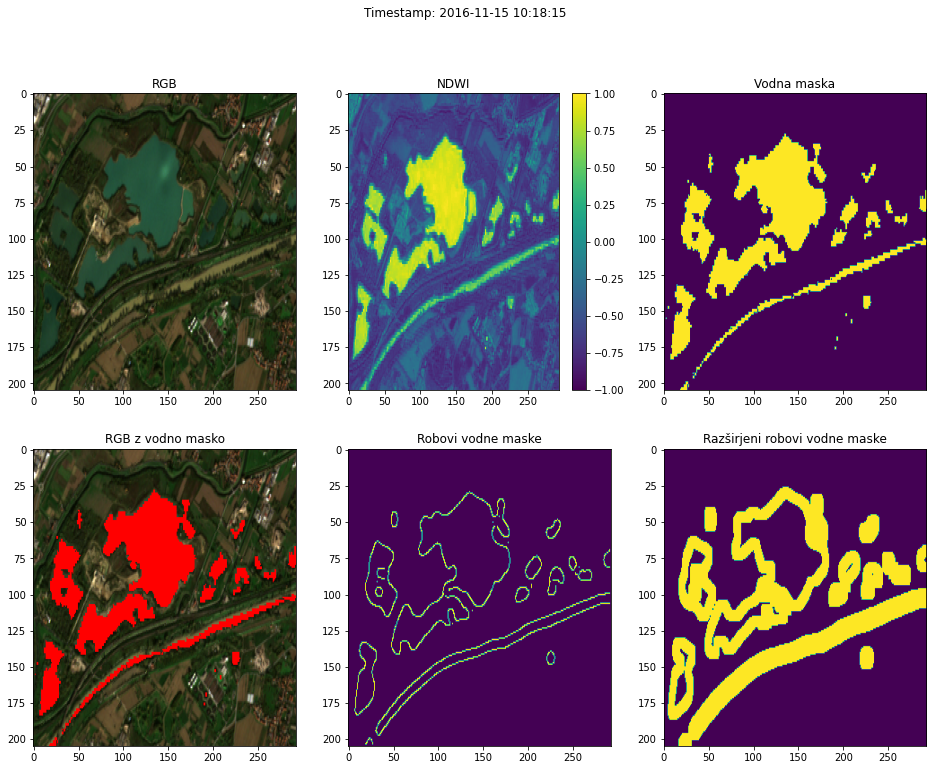

In [4]:
(water_mask1, water_edges1, shores1, shores_edges1) = get_water_mask(
    eopatch1,
    water_treshhold=0.5,
    canny_sigma=3,
    gauss_sigma=0.75
)

visualise_water_mask(band_names, eopatch1, 0, water_mask1, water_edges1, shores1, shores_edges1)

(69, 1)


,NDWI,Hydrometry_Nave_di_Rosano
NDWI,1.000000,0.752691
Hydrometry_Nave_di_Rosano,0.752691,1.000000


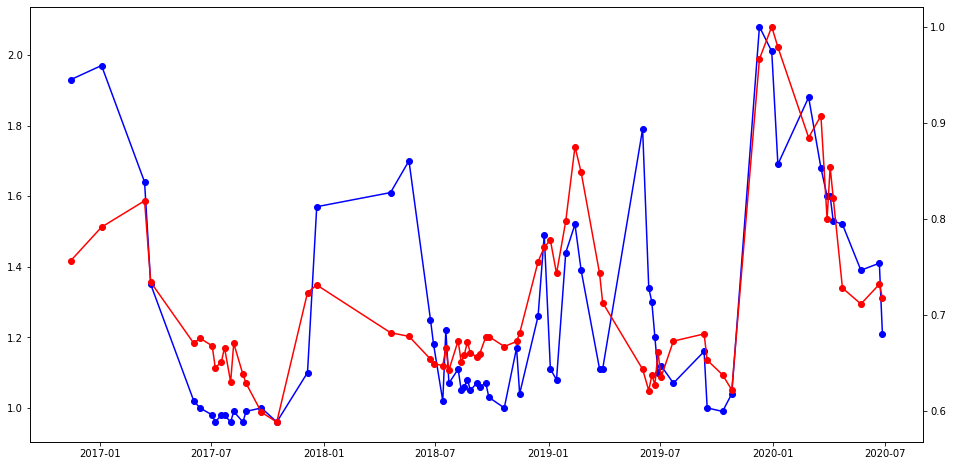

In [5]:
eo1, _ = myNDWI_index(eopatch1, shores1, -0.2)
print(eo1.shape)
eo1['NDWI'] /= max(eo1['NDWI'])

eo1 = eo1.merge(df['Hydrometry_Nave_di_Rosano'], how='inner', left_index=True, right_index=True)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

ax.plot(eo1['Hydrometry_Nave_di_Rosano'], color='blue', linestyle='-', marker='o', label='River Level')
ax.twinx().plot(eo1['NDWI'], color='red', linestyle='-', marker='o', label='NDWI')

eo1.corr()

In [6]:
eopatch2 = get_eopatch(
    './data/03_EO_River_Arno_2',
    ((43.71601307888001, 11.449397371600883), (43.73186067794631, 11.47044068641741)),
    time_range,
)
eopatch2

eopatch data was loaded from local directory


EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(68, 181, 164, 7), dtype=float32)
    NDVI: numpy.ndarray(shape=(68, 181, 164, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(68, 181, 164, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(68, 181, 164, 1), dtype=uint8)
    CLP: numpy.ndarray(shape=(68, 181, 164, 1), dtype=uint8)
    IS_DATA: numpy.ndarray(shape=(68, 181, 164, 1), dtype=bool)
    VALID_DATA: numpy.ndarray(shape=(68, 181, 164, 1), dtype=bool)
  }
  scalar: {
    COVERAGE: numpy.ndarray(shape=(68, 1), dtype=float64)
  }
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 0.1
    service_type: 'processing'
    size_x: 164
    size_y: 181
    time_difference: datetime.timedelta(days=1)
    time_interval: ('2015-01-01T00:00:00', '2020-06-30T23:59:59')
  }
  bbox: BBox(((11.449397371600883, 43.71601307888001), (11.47044068641741, 43.73186067794631)), crs=CR

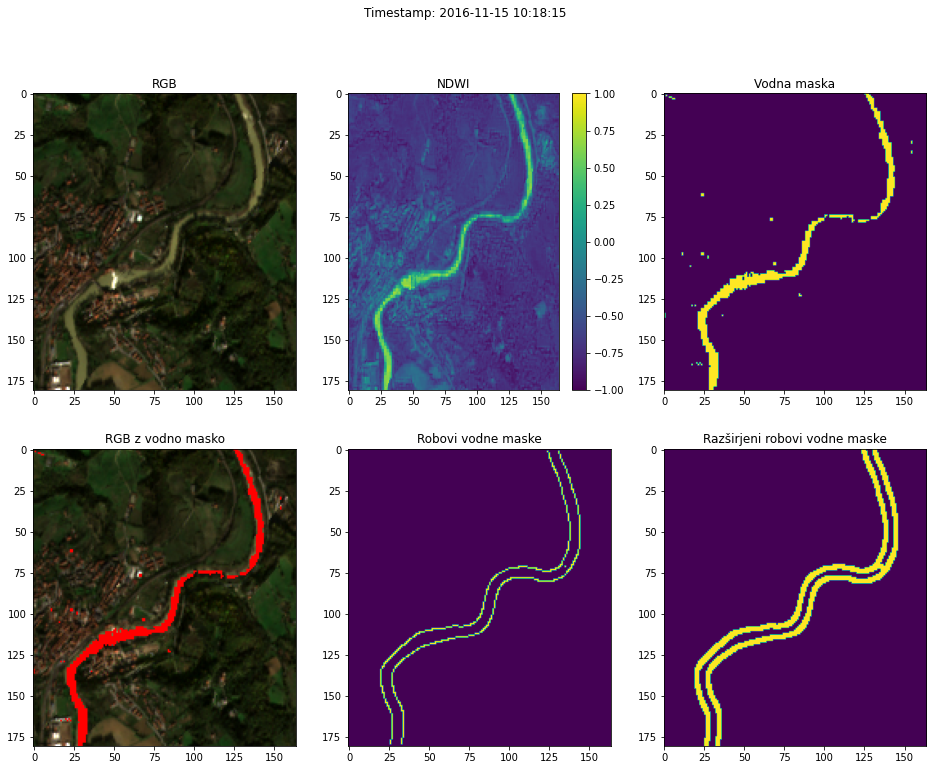

In [7]:
(water_mask2, water_edges2, shores2, shores_edges2) = get_water_mask(
    eopatch2,
    water_treshhold=0.2,
    canny_sigma=3,
    gauss_sigma=0.25
)

visualise_water_mask(band_names, eopatch2, 0, water_mask2, water_edges2, shores2, shores_edges2)

(68, 1)


,NDWI,Hydrometry_Nave_di_Rosano
NDWI,1.000000,0.850502
Hydrometry_Nave_di_Rosano,0.850502,1.000000


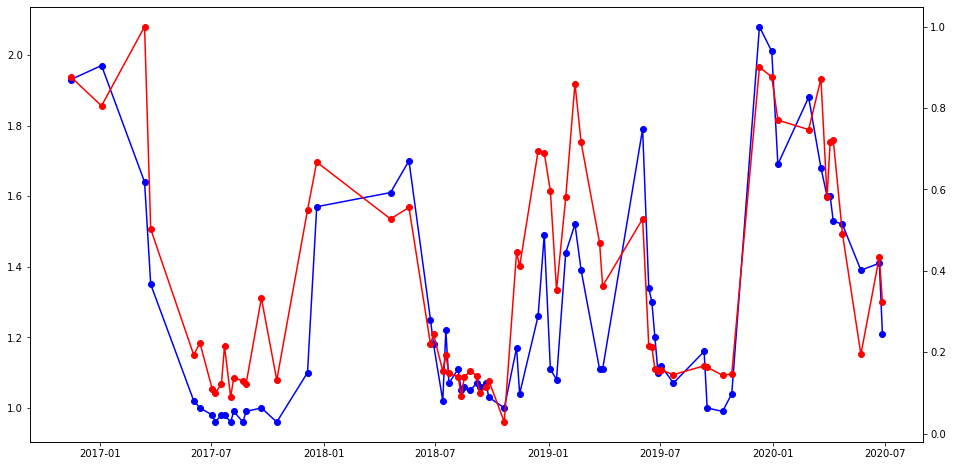

In [8]:
eo2, _ = myNDWI_index(eopatch2, shores2, -0.2)
print(eo2.shape)
eo2['NDWI'] /= max(eo2['NDWI'])

eo2 = eo2.merge(df['Hydrometry_Nave_di_Rosano'], how='inner', left_index=True, right_index=True)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

ax.plot(eo2['Hydrometry_Nave_di_Rosano'], color='blue', linestyle='-', marker='o', label='River Level')
ax.twinx().plot(eo2['NDWI'], color='red', linestyle='-', marker='o', label='NDWI')

eo2.corr()

In [9]:
eopatch3 = get_eopatch(
    './data/03_EO_River_Arno_3',
    ((43.781813459281096, 11.373689075239913), (43.792791533833096, 11.396638951219906)),
    time_range,
)
eopatch3

eopatch data was loaded from local directory


EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(69, 127, 181, 7), dtype=float32)
    NDVI: numpy.ndarray(shape=(69, 127, 181, 1), dtype=float32)
    NDWI: numpy.ndarray(shape=(69, 127, 181, 1), dtype=float32)
  }
  mask: {
    CLM: numpy.ndarray(shape=(69, 127, 181, 1), dtype=uint8)
    CLP: numpy.ndarray(shape=(69, 127, 181, 1), dtype=uint8)
    IS_DATA: numpy.ndarray(shape=(69, 127, 181, 1), dtype=bool)
    VALID_DATA: numpy.ndarray(shape=(69, 127, 181, 1), dtype=bool)
  }
  scalar: {
    COVERAGE: numpy.ndarray(shape=(69, 1), dtype=float64)
  }
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 0.1
    service_type: 'processing'
    size_x: 181
    size_y: 127
    time_difference: datetime.timedelta(days=1)
    time_interval: ('2015-01-01T00:00:00', '2020-06-30T23:59:59')
  }
  bbox: BBox(((11.373689075239913, 43.781813459281096), (11.396638951219906, 43.792791533833096)), crs

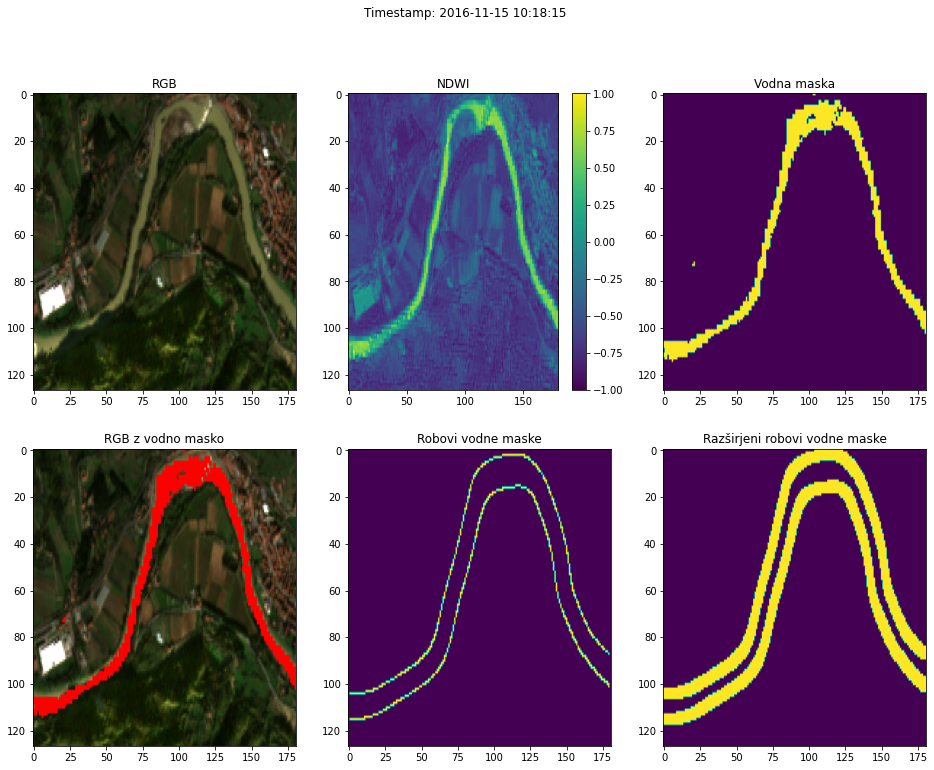

In [10]:
(water_mask3, water_edges3, shores3, shores_edges3) = get_water_mask(
    eopatch3,
    water_treshhold=0.4,
    canny_sigma=5,
    gauss_sigma=0.5
)

visualise_water_mask(band_names, eopatch3, 0, water_mask3, water_edges3, shores3, shores_edges3)

(69, 1)


,NDWI,Hydrometry_Nave_di_Rosano
NDWI,1.000000,0.871493
Hydrometry_Nave_di_Rosano,0.871493,1.000000


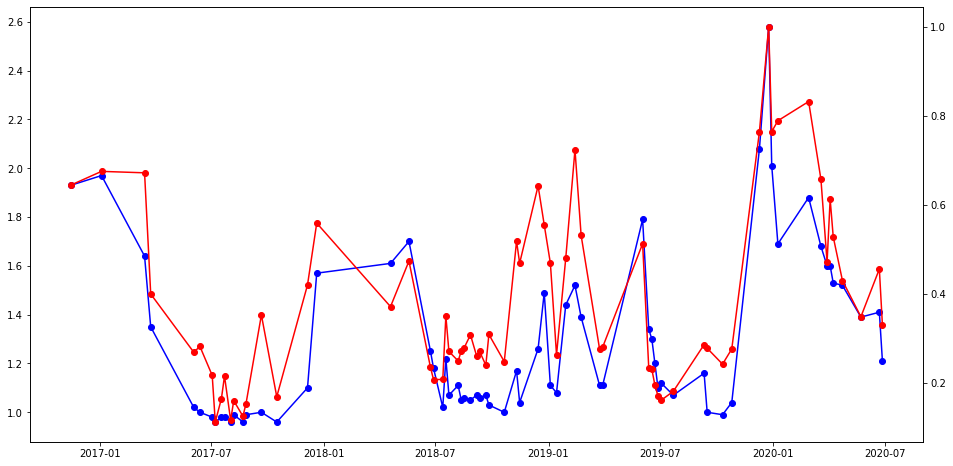

In [13]:
eo3, _ = myNDWI_index(eopatch3, shores3, -0.2)
print(eo3.shape)
eo3['NDWI'] /= max(eo3['NDWI'])

eo3 = eo3.merge(df['Hydrometry_Nave_di_Rosano'], how='inner', left_index=True, right_index=True)

fig, ax = plt.subplots(1, 1, figsize=(16, 8))

ax.plot(eo3['Hydrometry_Nave_di_Rosano'], color='blue', linestyle='-', marker='o', label='River Level')
ax.twinx().plot(eo3['NDWI'], color='red', linestyle='-', marker='o', label='NDWI')

eo3.corr()


Non-intersecting rows:
                  eo1  eo2  eo3
Date                          
2018-08-22  0.671551  NaN  NaN
2019-12-25       NaN  NaN  1.0


,eo1,eo2,eo3
eo1,1.000000,0.849293,0.858741
eo2,0.849293,1.000000,0.930520
eo3,0.858741,0.930520,1.000000


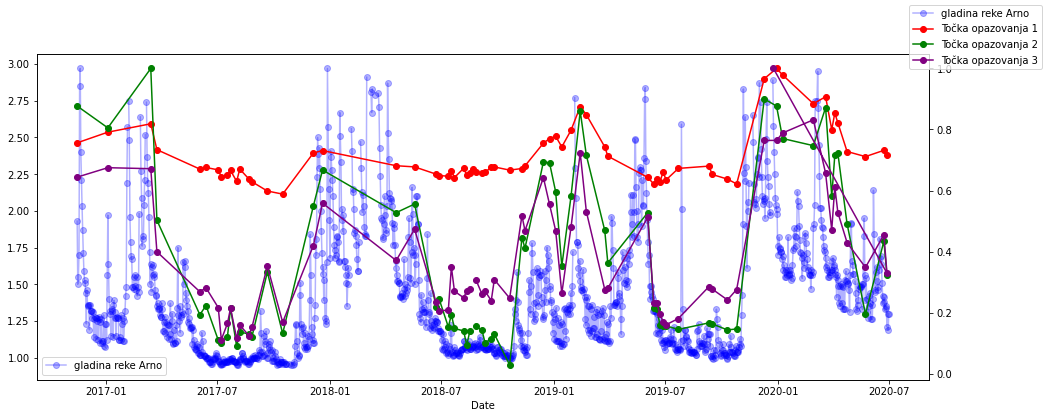

In [18]:
eo_m = pd.concat([
    eo1.rename(columns={'NDWI': 'eo1'})['eo1'],
    eo2.rename(columns={'NDWI': 'eo2'})['eo2'],
    eo3.rename(columns={'NDWI': 'eo3'})['eo3'],
], axis=1)

# print(eo_m)

print('\nNon-intersecting rows:\n', eo_m[eo_m.isna().any(axis=1)])


fig, ax = plt.subplots(1, 1, figsize=(16, 6))

df.loc[df.index >= eo_m.index.min(), 'Hydrometry_Nave_di_Rosano'].plot(
    linestyle='-',
    marker='o',
    ax=ax,
    color='blue',
    label='gladina reke',
    legend=True,
    alpha=0.3
)


ax2 = ax.twinx()
ax2.plot(eo_m['eo1'], color='red', marker='o', label='Točka opazovanja 1')
ax2.plot(eo_m['eo2'], color='green', marker='o', label='Točka opazovanja 2')
ax2.plot(eo_m['eo3'], color='purple', marker='o', label='Točka opazovanja 3')

fig.legend()

# eo_m = eo_m.merge(df['Hydrometry_Nave_di_Rosano'], how='left', left_index=True, right_index=True)

# fig, ax = plt.subplots(1, 1, figsize=(16, 8))

# ax.plot(eo_m['Hydrometry_Nave_di_Rosano'], color='blue', marker='o', label='River Level')

# ax2 = ax.twinx()
# ax2.plot(eo_m['eo1'], color='red', marker='o', label='eo1')
# ax2.plot(eo_m['eo2'], color='green', marker='o', label='eo2')
# ax2.plot(eo_m['eo3'], color='purple', marker='o', label='eo3')

# 
eo_m.corr()

![SegmentLocal](results/S2L2A-Orbit-Firence.gif "segment")